Chargement des résultats HMM...
Régimes identifiés : Bull=0, Bear=1, Crash=2

=== PERFORMANCE REPORT ===
                  S&P 500 (Benchmark)  HMM Strategy
Total Return                22.330456     92.270921
Ann. Return                  0.086411      0.126756
Ann. Volatility              0.183972      0.141679
Sharpe Ratio                 0.469698      0.894670
Max Drawdown                -0.567754     -0.356056
VaR 95% (Daily)             -0.017249     -0.014549
CVaR 95% (Daily)            -0.027601     -0.020872


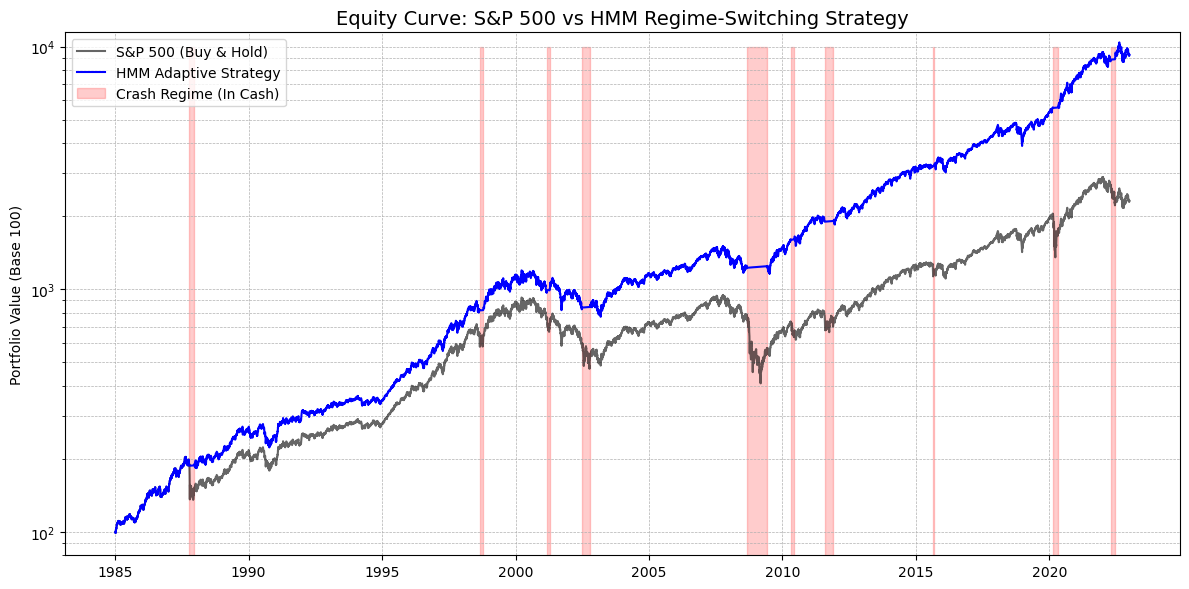

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. CHARGEMENT ET PRÉPARATION
# ==========================================
print("Chargement des résultats HMM...")
df = pd.read_csv("output_results.csv") # Ton fichier généré par le C++
dates = pd.read_csv("input_dates.csv", header=None, names=["Date"]) # Tes dates
df['Date'] = pd.to_datetime(dates['Date'])
df.set_index('Date', inplace=True)

# Identification des régimes (comme avant)
# On suppose que l'état avec la plus haute volatilité est le Crash
regime_stats = df.groupby('Regim_Viterbi')['Vol_Regim'].mean().sort_values()
bull_idx = regime_stats.index[0]  # Low Vol
bear_idx = regime_stats.index[1]  # Med Vol
crash_idx = regime_stats.index[2] # High Vol

print(f"Régimes identifiés : Bull={bull_idx}, Bear={bear_idx}, Crash={crash_idx}")

# ==========================================
# 2. STRATÉGIE D'ALLOCATION (Chapitre 3)
# ==========================================
# Paramètres
risk_free_rate_annual = 0.02 # 2% par an pour le Cash/Treasury
risk_free_rate_daily = risk_free_rate_annual / 252

# Stratégie :
# Si Régime prévu = Crash  -> On investit dans le sans risque (Cash)
# Si Régime prévu = Bull/Bear -> On investit dans le S&P 500
# Note: On utilise le régime à t pour décider l'allocation à t+1 (ou t selon données)
# Ici, on suppose que 'Regime_Viterbi' est l'état estimé pour la journée.

df['Strategy_Return'] = 0.0

# Masque pour les jours de Crash
is_crash = df['Regim_Viterbi'] == crash_idx

# Rendement S&P 500 (Log return vers Simple return pour le portefeuille)
# r_simple = exp(r_log) - 1
df['Market_Simple_Return'] = np.exp(df['Observation']) - 1

# Allocation
# Si Crash -> return = risk_free
# Sinon -> return = Market
df.loc[is_crash, 'Strategy_Return'] = risk_free_rate_daily
df.loc[~is_crash, 'Strategy_Return'] = df.loc[~is_crash, 'Market_Simple_Return']

# ==========================================
# 3. CALCUL DE PERFORMANCE (Chapitre 4)
# ==========================================
# Courbes de richesse (Base 100)
df['Wealth_Market'] = 100 * (1 + df['Market_Simple_Return']).cumprod()
df['Wealth_Strategy'] = 100 * (1 + df['Strategy_Return']).cumprod()

# Métriques
def calculate_metrics(series):
    total_return = (series.iloc[-1] / series.iloc[0]) - 1
    # Annualized Return (approx 252 trading days)
    n_years = len(series) / 252
    ann_return = (1 + total_return)**(1/n_years) - 1
    
    # Volatilité annuelle
    daily_returns = series.pct_change().dropna()
    ann_vol = daily_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio (Rf = 0 pour simplifier la comparaison relative)
    sharpe = ann_return / ann_vol
    
    # Max Drawdown
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # VaR & CVaR (95%) - Historique
    var_95 = np.percentile(daily_returns, 5) # 5% pire cas
    cvar_95 = daily_returns[daily_returns <= var_95].mean()
    
    return {
        'Total Return': total_return,
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'VaR 95% (Daily)': var_95,
        'CVaR 95% (Daily)': cvar_95
    }

metrics_mkt = calculate_metrics(df['Wealth_Market'])
metrics_str = calculate_metrics(df['Wealth_Strategy'])

# Affichage Table Comparatif
results_table = pd.DataFrame([metrics_mkt, metrics_str], index=['S&P 500 (Benchmark)', 'HMM Strategy'])
print("\n=== PERFORMANCE REPORT ===")
print(results_table.T)

# ==========================================
# 4. VISUALISATION
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Wealth_Market'], label='S&P 500 (Buy & Hold)', color='black', alpha=0.6)
plt.plot(df.index, df['Wealth_Strategy'], label='HMM Adaptive Strategy', color='blue', linewidth=1.5)

# Ajouter les zones de crash pour voir quand on est sorti
y_min, y_max = df['Wealth_Strategy'].min(), df['Wealth_Strategy'].max()
import matplotlib.collections as mcoll
def plot_regime_background(mask, color):
    if mask.sum() > 0:
        plt.fill_between(df.index, 0, 10000, where=mask, color=color, alpha=0.2, label='Crash Regime (In Cash)')

plot_regime_background(is_crash, 'red')

plt.title('Equity Curve: S&P 500 vs HMM Regime-Switching Strategy', fontsize=14)
plt.ylabel('Portfolio Value (Base 100)')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(min(df['Wealth_Market'].min(), 80), max(df['Wealth_Strategy'].max(), df['Wealth_Market'].max())*1.1)

plt.tight_layout()
plt.savefig("backtest_performance.png")
plt.show()